# Fitting Ne lines in a loop
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)

In [1]:
#!pip install --upgrade DiadFit

## Now import the packages you need
- When you communicate bugs with Penny, make sure you specify the version here.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
pf.__version__

'0.0.37'

##  Specifying paths
- Put your path here, e.g. where in your computer the spectra and metadata are saved

In [3]:
DayFolder=r'G:\My Drive\Berkeley_NEW\DiadFit_outer\docs\Examples\Diad_Fitting_Nov22nd2022'
meta_path=DayFolder +  '\MetaData'
spectra_path=DayFolder + '\Spectra'
filetype='headless_txt'

In [4]:
Ne_files=pf.get_Ne_files(path=spectra_path,
file_ext='txt', ID_str='N', 
exclude_str=['diad'], sort=False)

Ne_files[0:5]

['Ne1.txt', 'Ne10.txt', 'Ne11.txt', 'Ne12.txt', 'Ne13.txt']

### Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [5]:
wavelength =531.885 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.head()

,Raman_shift (cm-1),Intensity,Ne emission line in air
1,824.388824,5000.0,556.27662
9,1122.776289,5000.0,565.66588
16,1316.169507,5000.0,571.92248
19,1404.604434,5000.0,574.82985
23,1453.253923,7000.0,576.44188


### Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for each selected line

In [6]:
line_1=1122
line_2=1453
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
line1_shift=line_1, line2_shift=line_2,
cut_off_intensity=2000)
ideal_split

,Ne_Split,Line_1,Line_2,Entered Pos Line 1,Entered Pos Line 2
0,330.477634,1122.776289,1453.253923,1122,1453


## Select one file to tweak the fit for
- You can either do this numerically, or by specifiying the filename between ''

In [7]:
i=0 # Select one file
filename=Ne_files[i] 
print(filename)

Ne1.txt


## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
- This also prints the heights of the other peaks so you could choose other Neons if you wanted to

,Peak1_cent,Peak1_height,Peak2_cent,Peak2_height,Peak1_prom,Peak2_prom
5,1123.748842,1590.666626,1453.623079,13790.0,881.333313,13080.666687


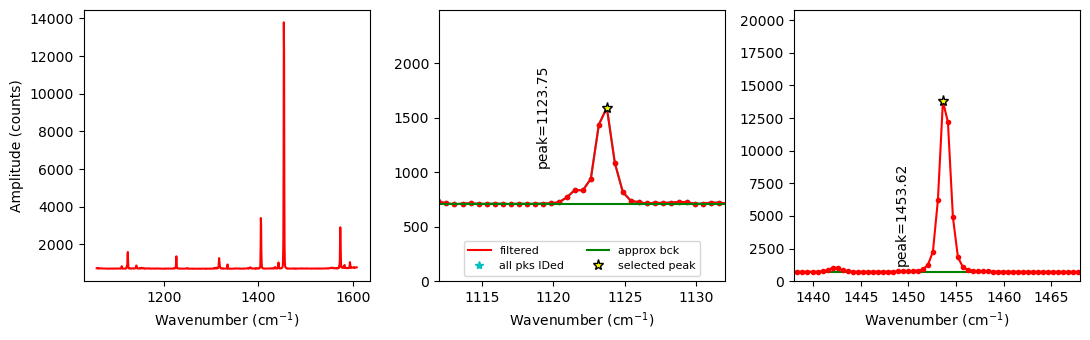

In [8]:
exclude_range_1=None
exclude_range_2=None


Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=filetype,
config=Neon_id_config, print_df=False)
df_fit_params

### Tweak peak parameters
- One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go. 
- Another thing is how many peaks you want for Peak1, 'peaks_1', for the 1117 line, you'll need 2 if you have the clear secondary peak seen above. 

In [9]:
pf.Ne_peak_config()

Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), peaks_1=2, DeltaNe_ideal=(330.477634,), x_range_baseline=20, y_range_baseline=200, pk1_sigma=0.4, pk2_sigma=0.4, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), x_span_pk1=None, x_span_pk2=None)

In [10]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.Ne_peak_config(model_name=model_name,
 DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=2, LH_offset_mini=[2, 5],
pk1_sigma=0.6, pk2_sigma=0.5,
lower_bck_pk1=(-40, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=5, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10],
N_poly_pk2_baseline=2 )

In [11]:
filename

'Ne1.txt'

,filename,pk2_peak_cent,pk2_amplitude,pk2_sigma,pk2_gamma,error_pk2,Peak2_Prop_Lor,pk1_peak_cent,pk1_amplitude,pk1_sigma,pk1_gamma,error_pk1,Peak1_Prop_Lor,deltaNe,Ne_Corr,Ne_Corr_min,Ne_Corr_max,residual_pk2,residual_pk1,residual_pk1+pk2
0,Ne1.txt,1453.824138,21207.705601,0.620331,None,0.00225,0.373892,1123.568549,1446.804886,0.628985,None,NaN,0.407646,330.255589,1.000672,NaN,NaN,41.666063,6.136637,47.8027


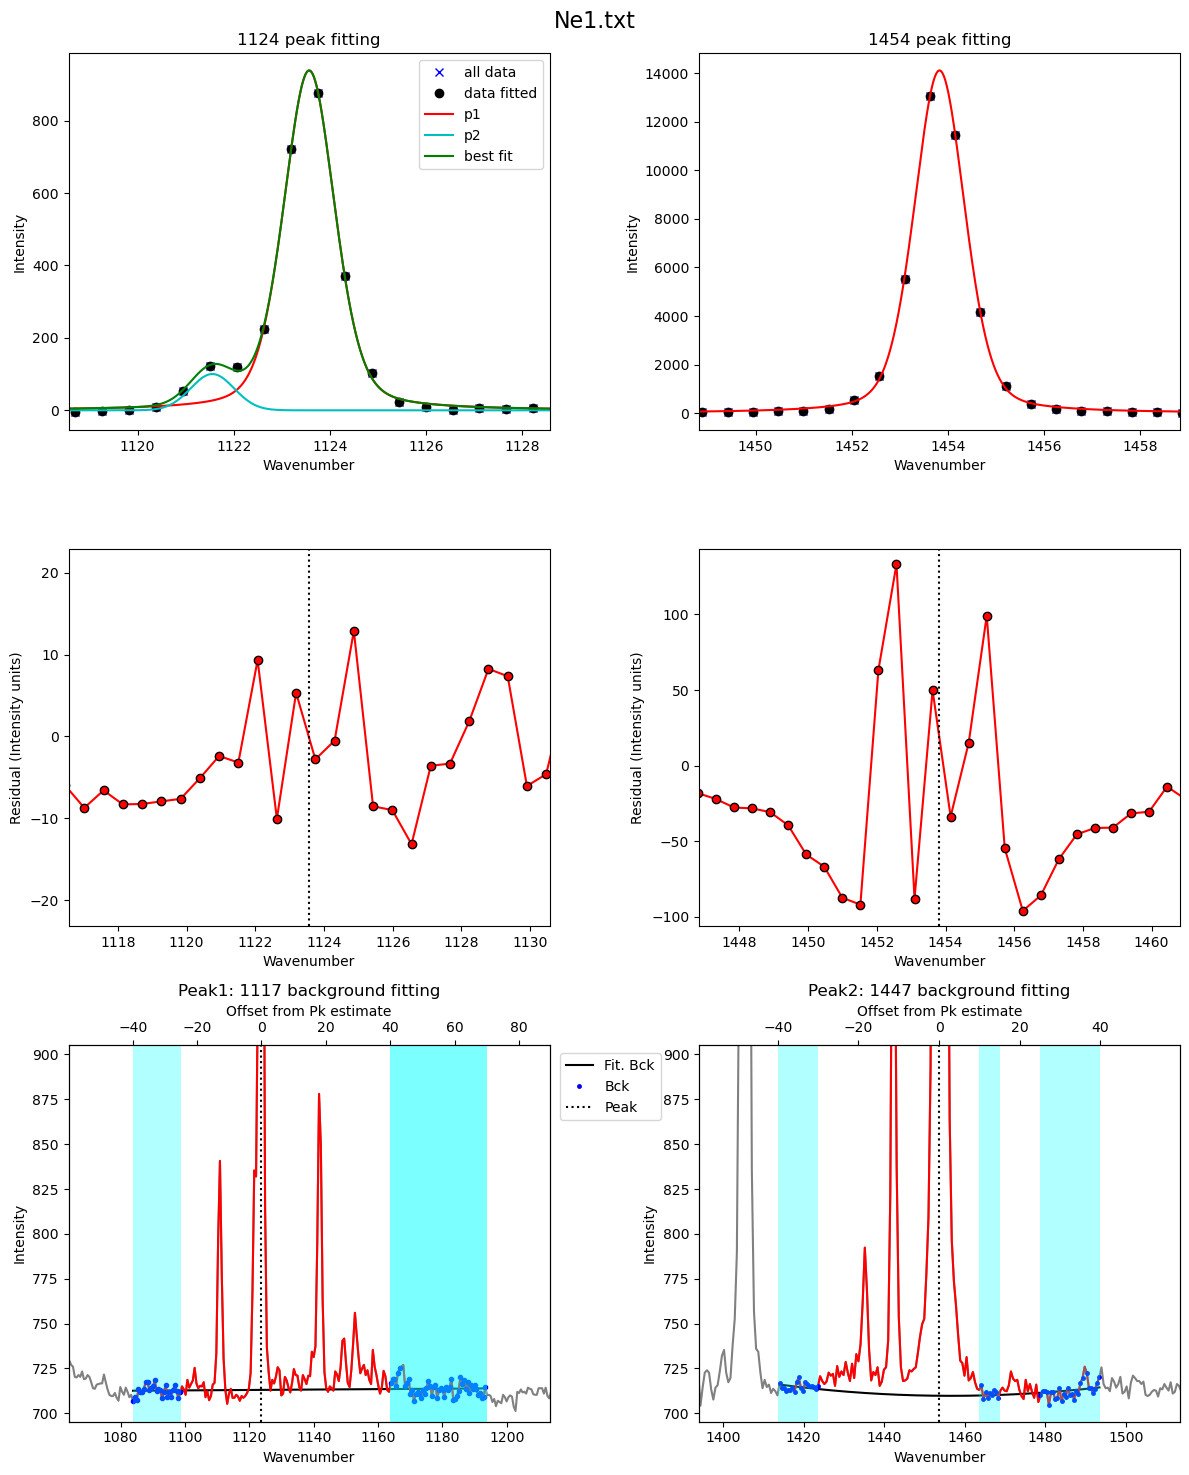

In [12]:
peaks_1=2

df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
path=spectra_path, prefix=False,
config=Ne_Config_est,
    Ne_center_1=df_fit_params['Peak1_cent'].iloc[i], 
    Ne_center_2=df_fit_params['Peak2_cent'].iloc[i],
    Ne_prom_1=df_fit_params['Peak1_prom'].iloc[i],
    Ne_prom_2=df_fit_params['Peak2_prom'].iloc[i],
    const_params=False)                                                                 
                                                                     
display(df_test_params)

In [13]:
## Update sigma based on this one fit
Ne_Config_tweak=Ne_Config_est
Ne_Config_tweak.pk1_sigma=df_test_params['pk1_sigma'].iloc[0]
Ne_Config_tweak.pk2_sigma=df_test_params['pk2_sigma'].iloc[0]

## Now fit all Ne files here using these parameters. 
- If you select plot_figure=False, the loop will be quick. 
- But if its True, you can to inspect the figures.

In [14]:
df2=pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
filetype=filetype, config_ID_peaks=Neon_id_config, config=Ne_Config_tweak,
df_fit_params=df_fit_params,                    
plot_figure=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:12<00:00,  5.95it/s]


In [15]:
df2

,filename,pk2_peak_cent,pk2_amplitude,pk2_sigma,pk2_gamma,error_pk2,Peak2_Prop_Lor,pk1_peak_cent,pk1_amplitude,pk1_sigma,pk1_gamma,error_pk1,Peak1_Prop_Lor,deltaNe,Ne_Corr,Ne_Corr_min,Ne_Corr_max,residual_pk2,residual_pk1,residual_pk1+pk2
0,Ne1.txt,1453.824138,21207.720215,0.620329,None,0.00225,0.373899,1123.568548,1446.814895,0.628977,None,NaN,0.407680,330.255590,1.000672,NaN,NaN,41.666553,6.136726,47.803279
1,Ne10.txt,1453.755113,21055.085839,0.631655,None,0.00240,0.354789,1123.473258,1624.144446,0.605182,None,NaN,0.479656,330.281855,1.000593,NaN,NaN,42.161836,6.204757,48.366593
2,Ne11.txt,1453.760641,20116.482403,0.629540,None,0.00237,0.368853,1123.483658,1621.751332,0.632812,None,NaN,0.408617,330.276983,1.000608,NaN,NaN,41.000977,5.842953,46.843929
3,Ne12.txt,1453.772985,19064.192945,0.635765,None,0.00219,0.354856,1123.501004,1465.369375,0.637743,None,NaN,0.417275,330.271981,1.000623,NaN,NaN,34.866349,5.799700,40.666049
4,Ne13.txt,1453.781044,18754.568569,0.631479,None,0.00233,0.367890,1123.494606,1478.965225,0.633105,None,NaN,0.467025,330.286438,1.000579,NaN,NaN,35.588475,5.975830,41.564305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,NE75.txt,1453.731504,19630.123092,0.636997,None,0.00258,0.371112,1123.448906,1700.844285,0.646652,None,NaN,0.392569,330.282598,1.000591,NaN,NaN,39.780449,6.382453,46.162901
73,NE76.txt,1453.733395,19420.489840,0.635770,None,0.00244,0.366737,1123.468025,1674.378488,0.640176,None,NaN,0.418026,330.265370,1.000643,NaN,NaN,38.319365,6.588452,44.907818
74,NE77.txt,1453.741119,19094.779621,0.636348,None,0.00233,0.363917,1123.455636,1566.008986,0.630900,None,NaN,0.457269,330.285482,1.000582,NaN,NaN,37.126254,7.009487,44.135741
75,Ne8.txt,1453.806207,20097.250903,0.626352,None,0.00242,0.370742,1123.525435,1555.398259,0.627523,None,NaN,0.468668,330.280772,1.000596,NaN,NaN,41.310306,6.709573,48.019880


## Now extract metadata to get a timestamp for each file

In [17]:
## Get meta files
Ne_files_meta=pf.get_Ne_files(path=meta_path,
file_ext='txt', ID_str='N', 
exclude_str=['diad'], sort=False)

Ne_files_meta[0:5]

['Ne1.txt', 'Ne10.txt', 'Ne11.txt', 'Ne12.txt', 'Ne13.txt']

In [18]:
meta=pf.stitch_metadata_in_loop(path=meta_path, 
Allfiles=Ne_files_meta, prefix=False)
meta.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:02<00:00, 32.44it/s]

Done
Oof, try not to work after midnight!


,filename,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center
64,NE68.txt,"November 29, 2020\n",November,29.0,NaN,45.0,3.0,5.0,"['0h', '2m', '16s']",12:07:01 AM\n,86821.0,1341.0
65,NE69.txt,"November 29, 2020\n",November,29.0,NaN,45.0,3.0,5.0,"['0h', '2m', '16s']",12:14:20 AM\n,87260.0,1341.0
67,NE70.txt,"November 29, 2020\n",November,29.0,NaN,45.0,3.0,5.0,"['0h', '2m', '17s']",12:21:12 AM\n,87672.0,1341.0
68,NE71.txt,"November 29, 2020\n",November,29.0,NaN,45.0,3.0,5.0,"['0h', '2m', '17s']",12:36:29 AM\n,88589.0,1341.0
69,NE72.txt,"November 29, 2020\n",November,29.0,NaN,45.0,3.0,5.0,"['0h', '2m', '17s']",12:44:10 AM\n,89050.0,1341.0


In [20]:
# Strip away suffix and prefix if needed
print(meta['filename'][0])

Ne1.txt


In [21]:
# remove these to get the pure file name you can compare 
file_m=pf.extracting_filenames_generic(names=meta['filename'],
    prefix=False, str_prefix=None,
   file_type='.txt')
file_m

array(['NE68', 'NE69', 'NE70', 'NE71', 'NE72', 'NE73', 'NE74', 'NE75',
       'NE76', 'NE77', 'Ne1', 'Ne2', 'Ne3', 'Ne4', 'Ne5', 'Ne6', 'Ne7',
       'Ne8', 'Ne9', 'Ne10', 'Ne11', 'Ne12', 'Ne13', 'Ne14', 'Ne15',
       'Ne16', 'Ne17', 'Ne18', 'Ne19', 'Ne20', 'Ne21', 'NE22', 'NE23',
       'NE24', 'NE25', 'NE26', 'NE27', 'NE28', 'NE29', 'NE30', 'NE31',
       'NE32', 'NE33', 'NE34', 'NE35', 'NE36', 'NE37', 'NE38', 'NE39',
       'NE40', 'NE41', 'NE42', 'NE43', 'NE44', 'NE45', 'NE46', 'NE47',
       'NE48', 'NE49', 'NE50', 'NE51', 'NE52', 'NE53', 'NE54', 'NE55',
       'NE56', 'NE57', 'NE58', 'NE59', 'NE60', 'NE61', 'NE62', 'NE63',
       'NE64', 'NE65', 'NE66', 'NE67'], dtype=object)

In [22]:
# Do the same for spectra, e.g., work out what you need to strip off
print(df2['filename'][0])

Ne1.txt


In [23]:
file_s=pf.extracting_filenames_generic(names=df2['filename'],
    prefix=False, str_prefix=' ',
   file_type='.txt')
file_s

array(['Ne1', 'Ne10', 'Ne11', 'Ne12', 'Ne13', 'Ne14', 'Ne15', 'Ne16',
       'Ne17', 'Ne18', 'Ne19', 'Ne2', 'Ne20', 'Ne21', 'NE22', 'NE23',
       'NE24', 'NE25', 'NE26', 'NE27', 'NE28', 'NE29', 'Ne3', 'NE30',
       'NE31', 'NE32', 'NE33', 'NE34', 'NE35', 'NE36', 'NE37', 'NE38',
       'NE39', 'Ne4', 'NE40', 'NE41', 'NE42', 'NE43', 'NE44', 'NE45',
       'NE46', 'NE47', 'NE48', 'NE49', 'Ne5', 'NE50', 'NE51', 'NE52',
       'NE53', 'NE54', 'NE55', 'NE56', 'NE57', 'NE58', 'NE59', 'Ne6',
       'NE60', 'NE61', 'NE62', 'NE63', 'NE64', 'NE65', 'NE66', 'NE67',
       'NE68', 'NE69', 'Ne7', 'NE70', 'NE71', 'NE72', 'NE73', 'NE74',
       'NE75', 'NE76', 'NE77', 'Ne8', 'Ne9'], dtype=object)

## Combine 2 dataframes
- Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [24]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')

## Now lets inspect changes in Ne correction factor with time
- Normally, you can spot outliers this way

In [25]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo_sort.to_excel('PseudoVoigt.xlsx')

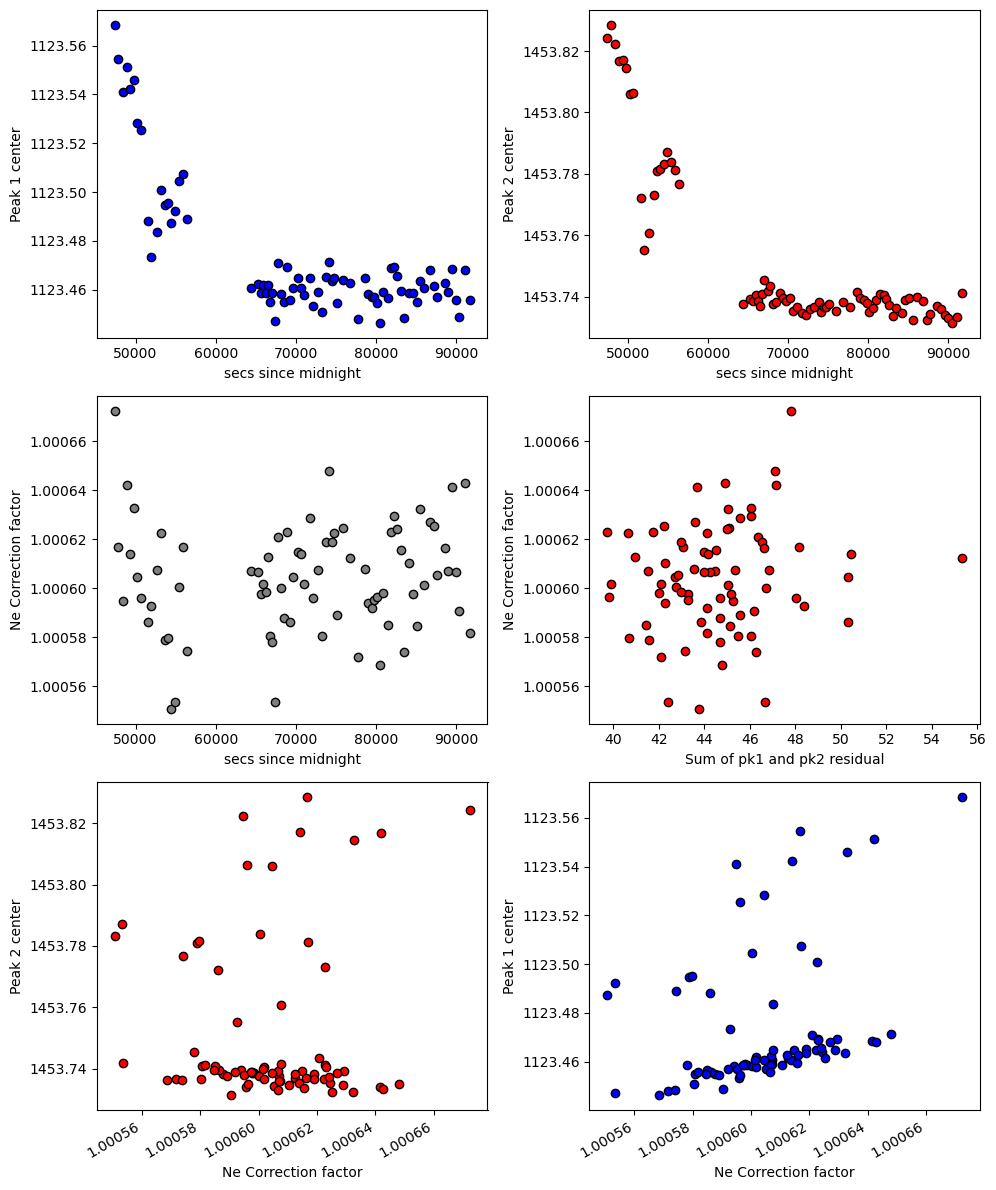

In [26]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


In [27]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo

,filename_x,pk2_peak_cent,pk2_amplitude,pk2_sigma,pk2_gamma,error_pk2,Peak2_Prop_Lor,pk1_peak_cent,pk1_amplitude,pk1_sigma,...,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center
0,Ne1.txt,1453.824138,21207.720215,0.620329,None,0.00225,0.373899,1123.568548,1446.814895,0.628977,...,November,28.0,NaN,45.0,3.0,50.0,"['0h', '2m', '16s']",1:09:44 PM\n,47384.0,1341.0
1,Ne10.txt,1453.755113,21055.085839,0.631655,None,0.00240,0.354789,1123.473258,1624.144446,0.605182,...,November,28.0,NaN,45.0,3.0,50.0,"['0h', '2m', '16s']",2:26:01 PM\n,51961.0,1341.0
2,Ne11.txt,1453.760641,20116.482403,0.629540,None,0.00237,0.368853,1123.483658,1621.751332,0.632812,...,November,28.0,NaN,45.0,3.0,50.0,"['0h', '2m', '16s']",2:36:59 PM\n,52619.0,1341.0
3,Ne12.txt,1453.772985,19064.192945,0.635765,None,0.00219,0.354856,1123.501004,1465.369375,0.637743,...,November,28.0,NaN,45.0,3.0,50.0,"['0h', '2m', '16s']",2:46:25 PM\n,53185.0,1341.0
4,Ne13.txt,1453.781044,18754.568569,0.631479,None,0.00233,0.367890,1123.494606,1478.965225,0.633105,...,November,28.0,NaN,45.0,3.0,50.0,"['0h', '2m', '16s']",2:53:28 PM\n,53608.0,1341.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,NE75.txt,1453.731504,19630.123092,0.636997,None,0.00258,0.371112,1123.448906,1700.844285,0.646652,...,November,29.0,NaN,45.0,3.0,5.0,"['0h', '2m', '17s']",1:06:41 AM\n,90401.0,1341.0
73,NE76.txt,1453.733395,19420.489840,0.635770,None,0.00244,0.366737,1123.468025,1674.378488,0.640176,...,November,29.0,NaN,45.0,3.0,5.0,"['0h', '2m', '17s']",1:18:29 AM\n,91109.0,1341.0
74,NE77.txt,1453.741119,19094.779621,0.636348,None,0.00233,0.363917,1123.455636,1566.008986,0.630900,...,November,29.0,NaN,45.0,5.0,5.0,"['0h', '3m', '47s']",1:28:42 AM\n,91722.0,1341.0
75,Ne8.txt,1453.806207,20097.250903,0.626352,None,0.00242,0.370742,1123.525435,1555.398259,0.627523,...,November,28.0,NaN,45.0,3.0,50.0,"['0h', '2m', '16s']",2:03:37 PM\n,50617.0,1341.0


In [28]:
df_combo_sort.to_clipboard(excel=True)

## Exclude ones that don't look right...
- The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
- Tweak offset and number_av until you exclude the ones that dont look right

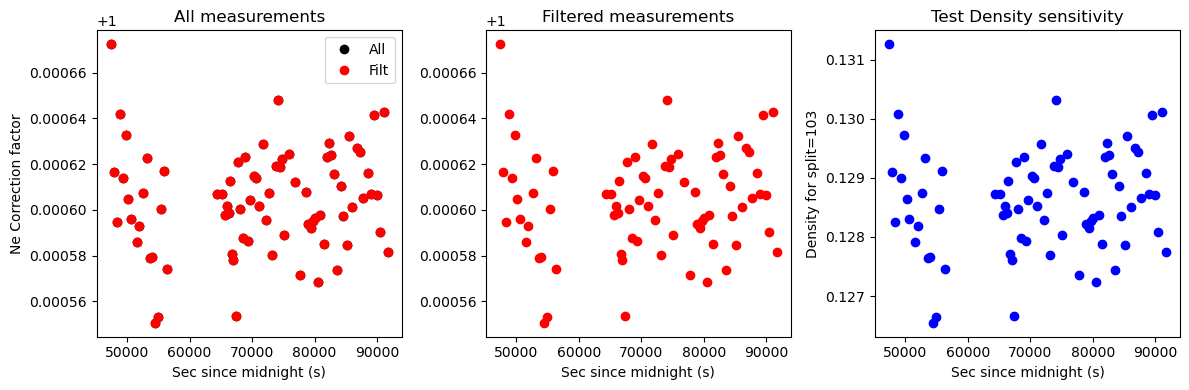

In [29]:
filt=pf.filter_Ne_Line_neighbours(Corr_factor=df_combo['Ne_Corr'], 
                    number_av=5, offset=0.0002)
# Now lets plot this to see
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='All')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Filt')
ax1.legend()
ax2.plot(df_combo['sec since midnight'], filt,  'or', label='Filt')

test_split=103
split=filt*test_split
density_test=pf.calculate_density_cornell(temp='SupCrit', Split=split)
ax3.plot(df_combo['sec since midnight'].loc[density_test['Preferred D']>0],
         density_test['Preferred D'].loc[density_test['Preferred D']>0], 'ob')


ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')
ax2.set_xlabel('Sec since midnight (s)')
ax2.set_title('Filtered measurements')
ax3.set_xlabel('Sec since midnight (s)')
ax3.set_ylabel('Density for split=' + str(test_split))
ax3.set_title('Test Density sensitivity')
fig.tight_layout()

## Now lets make a regression against time
- We take this time regression and then apply to our diad fits

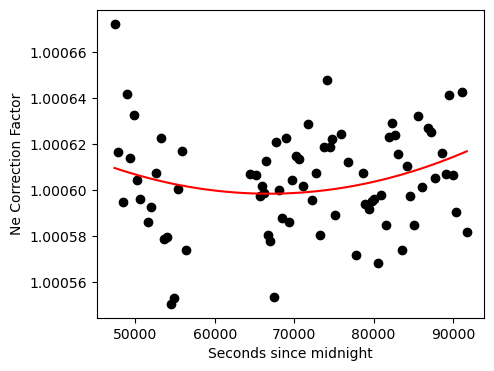

In [30]:
df_combo_filt=df_combo[density_test['Preferred D']>0]
model=pf.reg_Ne_lines_time(df=df_combo_filt, N_poly=2, fit='poly')

## SAving as pickle, can then load as a pickle

In [31]:
import pickle
with open('Ne_Line_Regression_Example_cali.pck', 'wb') as file_handle:
    pickle.dump(model, file_handle)